# Settings

## Imports

In [1]:
import sys,tweepy,csv,re, requests, json
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import os, time, re
import plotly.express as px

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Configs

In [3]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

#Changing dir
folder = 'ML'
try:
    os.chdir(f'{os.getcwd()}/{folder}')
except:
    dir = os.getcwd().replace(os.getcwd().split('/')[-1], folder)
    os.chdir(dir)

# Getting Twitter

## API

In [4]:
#token
config = dotenv_values(".env")
bearer_token = config['BEARER_TOKEN']

#connections
auth = tweepy.OAuth2BearerHandler({bearer_token})
api = tweepy.API(auth)




def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    #print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def get_tweet_v1(query, max_n):
    search_url = 'https://api.twitter.com/2/tweets/search/recent'
    tweets_dt = pd.DataFrame()

    print(f'Getting tweets...')

    try:
        # Querying the API
        json_response = connect_to_endpoint(search_url, query)
        
        try:
            tweets_dt = pd.DataFrame.from_dict(json_response['data'])
            
            try:
                n_token = json_response['meta']["next_token"]
                n = 0
                while n_token != 0 | n < max_n:
                    print(f'Next Token: {n} \n {n_token}')
                    query_next = query
                    query_next['next_token'] = n_token
                    json_response = connect_to_endpoint(search_url, query_next)
                    tweets_n = pd.DataFrame.from_dict(json_response['data'])
                    tweets_dt = pd.concat([tweets_dt,tweets_n], ignore_index=True)

                    n += 1
                    n_token = json_response['meta']["next_token"]
                
            except:
                print('Error to get next page')
        
        except:
            print('Error to get data from Json File')     

    except:
        print('Error to querying API')
        
    return tweets_dt


## Countries

Getting up to 1000 tweets each country

In [5]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',
        'Ireland', 'Italy', 'Latvia', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain','Sweden', 'Europe', 'UK']

filename = 'tweets_agri_2k.bz2'

if os.path.exists(filename) == False: 
    for c in countries:

        q = {
        'query': f'agriculture {c} -is:retweet',
        'max_results': 100,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        }

        t = get_tweet_v1(q, 10)
        t['country'] = c
        if c == countries[0]:
            tweets = t
        else:
            tweets = pd.concat([tweets, t], ignore_index=True)

    tweets.to_csv(filename, index=False,compression='bz2')
    print(f'File with {len(tweets)} saved.')

else:
    create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(filename))))
    print(f'Reading {filename}, created at {create_dt}')
    tweets = pd.read_csv(filename)
    print(f'File with {len(tweets)} Tweets')
    

tweets.sample()

Reading tweets_agri_2k.bz2, created at 06/01/2023 01:49:21
File with 2126 Tweets


public_metrics      conversation_id  \
652  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610232620335480833   

                                                  text reply_settings lang  \
652  @tinotennispires Yet we pay her day by day lik...       everyone   en   

     author_id   edit_history_tweet_ids                created_at  \
652  548632136  ['1610240897295486977']  2023-01-03T11:45:21.000Z   

               id  in_reply_to_user_id  \
652  1.610241e+18          325938100.0   

                                     referenced_tweets country  geo  
652  [{'type': 'replied_to', 'id': '161023412977321...  Europe  NaN

# Clean Your Text Data

## Worlds extractions

In [6]:
def clean_tweet(x, link, keyword, usernames):
    list_of_lists =[]
    if link == True:
        list_of_links = []
        words = x.split(' ')
        for word in words:
            if re.search('http', word):
                list_of_links.append(re.split("\W+",word.lower()))
        if len(list_of_links) > 0:
            list_of_lists.append(list_of_links[0])
    
    if keyword == True:
        list_of_keywords = []
        words = x.split()
        for word in words:
            if word.startswith('#'):
                list_of_keywords.append(word)
        if len(list_of_keywords) > 0:
            list_of_lists.append(list_of_keywords)
            
    if usernames == True:
        list_of_usernames = []
        words = x.split()
        for word in words:
            if word.startswith('@'):
                list_of_usernames.append(word.lower().replace('@',''))
        if len(list_of_usernames) > 0:
            list_of_lists.append(list_of_usernames)
    
    return  [item for sublist in list_of_lists for item in sublist]

        
# keyword extraction from tweets
def get_keywords(x):
    list_of_keywords = []
    words = x.split()
    for word in words:
        if word.startswith('#'):
            list_of_keywords.append(word)
    return list_of_keywords


In [7]:
tweets = tweets[tweets.lang == 'en']
tweets = tweets.reset_index(drop = True)

In [8]:
list_of_lists = tweets['text'].apply(lambda tweet : clean_tweet(tweet, link = True, keyword = False, usernames = True))
rem_list = [item for sublist in list_of_lists for item in sublist]

tweets['text_c'] = tweets['text'].apply( lambda tweet : ' '.join([word for word in re.split("\W+",tweet) if word.lower() not in rem_list]))

In [9]:
tweets['keywords'] = tweets['text'].apply( lambda tweet : get_keywords(tweet) )

In [10]:
tweets.sample(2)

public_metrics      conversation_id  \
1204  {'retweet_count': 0, 'reply_count': 1, 'like_c...  1604415368441004032   
482   {'retweet_count': 2, 'reply_count': 0, 'like_c...  1610968378163830787   

                                                   text reply_settings lang  \
1204  @johnmuffit @AnneJackson18 @digitalsunshine La...       everyone   en   
482   Agriculture as an industry is keen to clean up...       everyone   en   

                author_id   edit_history_tweet_ids                created_at  \
1204  1587096670436790274  ['1605249344944631808']  2022-12-20T17:10:42.000Z   
482                786764  ['1610968378163830787']  2023-01-05T11:56:06.000Z   

                id  in_reply_to_user_id  \
1204           NaN          631016536.0   
482   1.610968e+18                  NaN   

                                      referenced_tweets country  geo  \
1204  [{'type': 'replied_to', 'id': '160524662207779...      UK  NaN   
482                                                 NaN      UK  NaN   

                                                 text_c keywords  
1204  Land is expensive in because we a tiny island ...       []  
482   as is keen to clean its act on emissions so wh...       []

In [11]:
n =45
print('OLD: ', tweets['text'][n], '\n')
print('NEW: ', tweets['text_c'][n])

OLD:  @EU_Commission @EUInterpreters Cpec rpec projects 🌊💦 electric gas dam sugar steel mill cloth machines agriculture machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees 🎁🎁 gift 🎁 china japan korea german Honduras Astonia Salvador France 

NEW:  Cpec rpec projects electric gas dam sugar steel mill cloth machines machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees gift china japan korea german Honduras Astonia Salvador France


In [12]:
len(tweets)

1409

## PorterStemmer

In [13]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [14]:
def stemming(df, text_col, name_new_col):
    # Store the column of the dataframe named as "text"
    X = df[text_col]
    cleaned_data=[]
    # For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
    for i in range(len(X)):
        text = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
        text = text.lower().split()
        text = [stemmer.stem(word) for word in text if (word not in stop_words) and (word not in punct)]
        text = ' '.join(text)
        df.loc[ i ,name_new_col] = text
    print('Stemmer done!')

In [15]:
stemming(tweets, 'text_c', 'text_ps')

Stemmer done!


In [16]:
n =0
print('ORIGINAL: ', tweets['text'][n], '\n')
print('CLEAN: ', tweets['text_c'][n], '\n')
print('STEMMER: ', tweets['text_ps'][n])

ORIGINAL:  Academic spam is great! I've been invited to be a keynote speaker at a Plant Biology conference in Vienna 😂
95% sure it's spam, but tempted to say yes! Imagine it's legit and I find myself in Austria, speaking to a room of stunned plant experts about WWII Scottish agriculture... 

CLEAN:  Academic spam is great I ve been invited to be a keynote speaker at a Plant Biology conference in Vienna 95 sure it s spam but tempted to say yes Imagine it s legit I myself in Austria speaking to a room of stunned plant experts about WWII Scottish 

STEMMER:  academ spam great invit keynot speaker plant biolog confer vienna sure spam tempt say ye imagin legit austria speak room stun plant expert wwii scottish


## Sentiment Analyzes

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. [link](https://textblob.readthedocs.io/en/dev/index.html)

In [17]:
tweets.sample(2)

public_metrics      conversation_id  \
1025  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1603595017674805248   
660   {'retweet_count': 3, 'reply_count': 1, 'like_c...  1609821807669874689   

                                                   text reply_settings lang  \
1025  @PhoenixTV_News Cpec rpec projects 🌊💦 electric...       everyone   en   
660   One week to go!\n\nA FREE Regenerative Agricul...       everyone   en   

                author_id   edit_history_tweet_ids                created_at  \
1025  1566407156576002050  ['1604822271230713856']  2022-12-19T12:53:40.000Z   
660            3431509390  ['1609821807669874689']  2023-01-02T08:00:02.000Z   

                id  in_reply_to_user_id  \
1025           NaN         1.532255e+18   
660   1.609822e+18                  NaN   

                                      referenced_tweets country  geo  \
1025  [{'type': 'replied_to', 'id': '160359501767480...  German  NaN   
660                                                 NaN      UK  NaN   

                                                 text_c keywords  \
1025  Cpec rpec projects electric gas dam sugar stee...       []   
660   One to go A FREE Regenerative Open Event tailo...       []   

                                                text_ps  
1025  cpec rpec project electr ga dam sugar steel mi...  
660   one go free regen open event tailor north engl...

In [18]:
for i in tweets.index:
    text = tweets.loc[i,'text_ps']
    tweets.loc[i, 'TextBlob'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

public_metrics      conversation_id  \
685  {'retweet_count': 0, 'reply_count': 1, 'like_c...  1609355214880137216   
477  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610990803412721664   

                                                  text reply_settings lang  \
685  @alanmoore1967 @Stephen65099192 @MatthewStadle...       everyone   en   
477  The Food Chain Should Be a Food Circle https:/...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
685  1546410137090408448  ['1609557770730180618']  2023-01-01T14:30:51.000Z   
477           2281901101  ['1610990803412721664']  2023-01-05T13:25:12.000Z   

               id  in_reply_to_user_id  \
685  1.609558e+18         3.292153e+09   
477  1.610991e+18                  NaN   

                                     referenced_tweets country  geo  \
685  [{'type': 'replied_to', 'id': '160951323644078...      UK  NaN   
477                                                NaN      UK  NaN   

                                                text_c  \
685  On your page you say you How is going since re...   
477  Chain Should Be a Circle FoodSecurity Science ...   

                                    keywords  \
685                                       []   
477  [#FoodSecurity, #Agriculture, #Science]   

                                     text_ps  TextBlob   Vader  
685  page say go sinc remov freedom movement       0.0  0.6369  
477  chain circl foodsecur scienc fxgneo nmn       0.0  0.0000

In [19]:
for i in tweets.index:
    text = tweets.loc[i,'text_c']
    tweets.loc[i, 'TextBlob_c'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_c'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
for i in tweets.index:
    text = tweets.loc[i,'text']
    tweets.loc[i, 'TextBlob_o'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_o'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

public_metrics      conversation_id  \
739   {'retweet_count': 0, 'reply_count': 0, 'like_c...  1607368758942744577   
1010  {'retweet_count': 1, 'reply_count': 0, 'like_c...  1605543298315063296   

                                                   text reply_settings lang  \
739   @TheGreenParty @AdrianRamsay But not for enfor...       everyone   en   
1010  🇩🇪 Agriculture Minister @cem_oezdemir wants to...       everyone   en   

       author_id   edit_history_tweet_ids                created_at  \
739     39524149  ['1608866922694873090']  2022-12-30T16:45:40.000Z   
1010  2893273911  ['1605543298315063296']  2022-12-21T12:38:46.000Z   

                id  in_reply_to_user_id  ...  \
739   1.608867e+18           15529670.0  ...   
1010           NaN                  NaN  ...   

                                   geo  \
739   {'place_id': '3d9aefed42dda147'}   
1010                               NaN   

                                                 text_c keywords  \
739   But not for enforceable limits on immigration ...       []   
1010  Minister wants to make sure that it is possibl...       []   

                                                text_ps TextBlob   Vader  \
739   enforc limit immigr sustain popul level conseq...     0.00  0.5057   
1010  minist want make sure possibl easi everyon ger...     0.25  0.5719   

      TextBlob_c  Vader_c  TextBlob_o  Vader_o  
739     0.000000  -0.7476    0.000000  -0.7476  
1010    0.247619   0.7430    0.247619   0.7430  

[2 rows x 22 columns]

In [20]:
def get_polarity(df, col):

    polarity = 0
    neutral = 0
    wpositive = 0
    positive = 0
    spositive = 0
    wnegative = 0
    negative = 0
    snegative = 0
     
    for t in df.index:
        
        v = df.loc[t, col]
        polarity += v  # adding up polarities to find the average later

        if (v == 0):  # adding reaction of how people are reacting to find average later
            neutral += 1
            desc = 'neutral'
        elif (v > 0 and v <= 0.3):
            wpositive += 1
            desc ='weak_positive'
        elif (v > 0.3 and v <= 0.6):
            positive += 1
            desc = 'positive'
        elif (v > 0.6 and v <= 1):
            spositive += 1
            desc = 'strong_positive'
        elif (v > -0.3 and v <= 0):
            wnegative += 1
            desc = 'weak_negative'
        elif (v > -0.6 and v <= -0.3):
            negative += 1
            desc = 'negative'
        elif (v > -1 and v <= -0.6):
            snegative += 1
            desc = 'strong_negative'
         
        df.loc[t, f'{col}_desc'] = desc
        

    return {'polarity_sum':polarity,
            'polarity_mean':(polarity / len(df)),
            'neutral':neutral,
            'strong_positive':spositive,
            'positive':positive,
            'weak_positive':wpositive,
            'weak_negative':wnegative,
            'negative':negative,
            'strong_negative':snegative}




In [21]:
get_polarity(tweets,'TextBlob')

{'polarity_sum': 116.520942927443,
 'polarity_mean': 0.08269761740769553,
 'neutral': 557,
 'strong_positive': 42,
 'positive': 153,
 'weak_positive': 430,
 'weak_negative': 183,
 'negative': 38,
 'strong_negative': 4}

In [22]:
get_polarity(tweets,'TextBlob_o')

{'polarity_sum': 178.88707275132285,
 'polarity_mean': 0.1269603071336571,
 'neutral': 322,
 'strong_positive': 36,
 'positive': 244,
 'weak_positive': 586,
 'weak_negative': 187,
 'negative': 30,
 'strong_negative': 3}

In [23]:
get_polarity(tweets,'TextBlob_c')

{'polarity_sum': 145.64600258207412,
 'polarity_mean': 0.1033683481774834,
 'neutral': 376,
 'strong_positive': 37,
 'positive': 182,
 'weak_positive': 570,
 'weak_negative': 207,
 'negative': 32,
 'strong_negative': 4}

In [24]:
get_polarity(tweets,'Vader')

{'polarity_sum': 215.27659999999992,
 'polarity_mean': 0.1527867991483321,
 'neutral': 441,
 'strong_positive': 206,
 'positive': 355,
 'weak_positive': 136,
 'weak_negative': 87,
 'negative': 121,
 'strong_negative': 63}

In [25]:
get_polarity(tweets,'Vader_o')

{'polarity_sum': 304.66490000000016,
 'polarity_mean': 0.21622775017743093,
 'neutral': 281,
 'strong_positive': 404,
 'positive': 284,
 'weak_positive': 109,
 'weak_negative': 99,
 'negative': 120,
 'strong_negative': 112}

In [26]:
get_polarity(tweets,'Vader_c')

{'polarity_sum': 283.40110000000084,
 'polarity_mean': 0.20113633782824758,
 'neutral': 292,
 'strong_positive': 323,
 'positive': 350,
 'weak_positive': 131,
 'weak_negative': 106,
 'negative': 110,
 'strong_negative': 97}

In [27]:
tweets.sample()

public_metrics      conversation_id  \
371  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610209288907104258   

                                                  text reply_settings lang  \
371  #Gas and renewables boss Wael Sawan among cand...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
371  1584319430560862208  ['1610209288907104258']  2023-01-03T09:39:45.000Z   

               id  in_reply_to_user_id  ... TextBlob_c Vader_c TextBlob_o  \
371  1.610209e+18                  NaN  ...        0.0     0.0        0.0   

    Vader_o  TextBlob_desc TextBlob_o_desc  TextBlob_c_desc  Vader_desc  \
371     0.0  weak_positive         neutral          neutral     neutral   

     Vader_o_desc  Vader_c_desc  
371       neutral       neutral  

[1 rows x 28 columns]

In [28]:
##Checking Twitters

n = 1015
print('\nText Original:', tweets.loc[n, 'text'], '\n',
     '-------------------------------------------------------------------------------------------')
print('Text Clear:', tweets.loc[n, 'text_c'], '\n',
     '-------------------------------------------------------------------------------------------')

print('Text Steammed:', tweets.loc[n, 'text_ps'], '\n',
     '-------------------------------------------------------------------------------------------')

print('KeyWords:', tweets.loc[n, 'keywords'], '\n',
     '-------------------------------------------------------------------------------------------')

print('\nTextBlob')
print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

print('\nVader')
print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])




Text Original: #Haryana one of most important #agricultural producers in #India. Discussed with @hafedharyana MD A. Srinivas how #German #technologies &amp; #solutions can support #farmers in #sustainable &amp; productive #agriculture - benefiting millions of farmers in the State. Many opportunities! https://t.co/bA0TCypjdm 
 -------------------------------------------------------------------------------------------
Text Clear: Haryana one of most important agricultural producers in India Discussed with MD A Srinivas how German technologies amp can in sustainable amp productive benefiting millions of in State Many opportunities 
 -------------------------------------------------------------------------------------------
Text Steammed: haryana one import agricultur produc india discuss md sriniva german technolog amp sustain amp product benefit million state mani opportun 
 -------------------------------------------------------------------------------------------
KeyWords: ['#Haryana'

In [29]:
def Count_Values(df, columns):
    for c in columns:
        if c == columns[0]:
            data = df[f'{c}'].value_counts().to_frame().reset_index()
        else:
            data = data.merge(tweets[f'{c}'].value_counts().to_frame().reset_index(), on=['index'])
    
    data = data.rename(columns={'index':'values'})
    return data

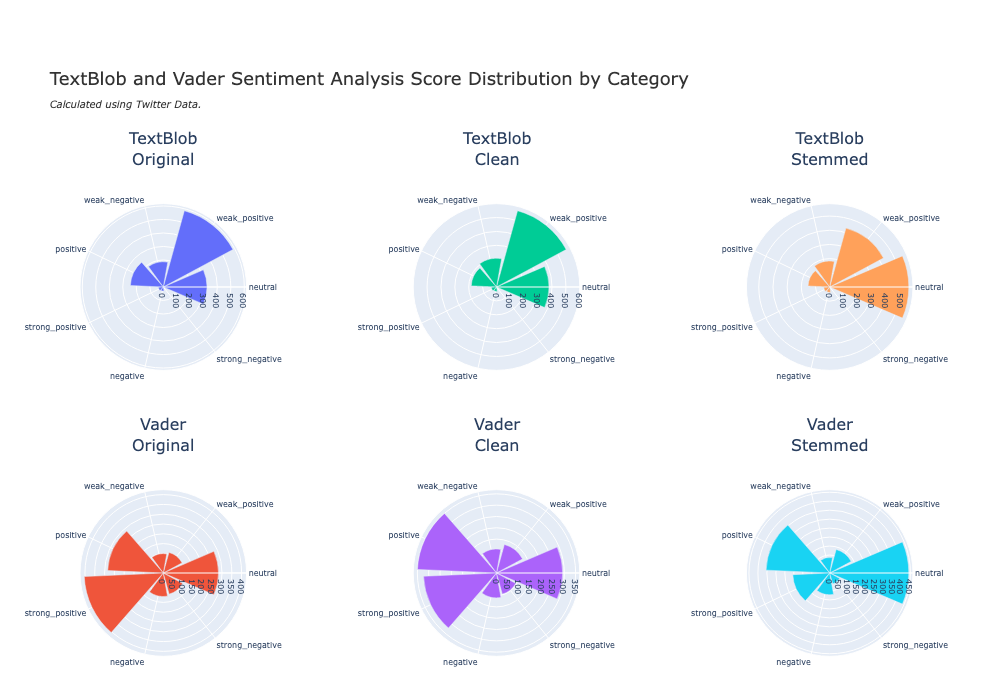

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

col = ['TextBlob_desc', 'Vader_desc', 'TextBlob_o_desc',
       'TextBlob_c_desc', 'Vader_c_desc', 'Vader_o_desc']

m = Count_Values(df = tweets,
                 columns = col)

title = f'TextBlob and Vader Sentiment Analysis Score Distribution by Category' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig = make_subplots(
    rows=2, cols=3,
    vertical_spacing=0.1,
    horizontal_spacing=0.2,
    specs=[[{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}],
          [{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}]],
    subplot_titles=("TextBlob<br>Original",
                    "TextBlob<br>Clean",
                    "TextBlob<br>Stemmed",
                   "Vader<br>Original", "Vader<br>Clean","Vader<br>Stemmed")

)

# Row 1 = TextBlob | Row 2 = Vader

#col 1 = Original
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_o_desc']),
              row=1, col=1)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_o_desc']),
              row=2, col=1)


#col 2 = Clean
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_c_desc']),
              row=1, col=2)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_c_desc']),
              row=2, col=2)

#col 3 = Stemmed
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_desc']),
              row=1, col=3)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_desc']),
              row=2, col=3)


fig.update_layout(
    showlegend=False,
    font_size=8,
    title_font_size=18,
    title_text=title,
    title_font_color='#333333',
    width = 1200,
    height=700,
    plot_bgcolor='white',
    margin_t=170,
    margin_b=10)

fig.show()

There is clearly a loss of intensity in the analysis of the tools, classifying texts more neutrally after the text treatment phases, since these tools use removed characters to calculate the intensity of emotions.

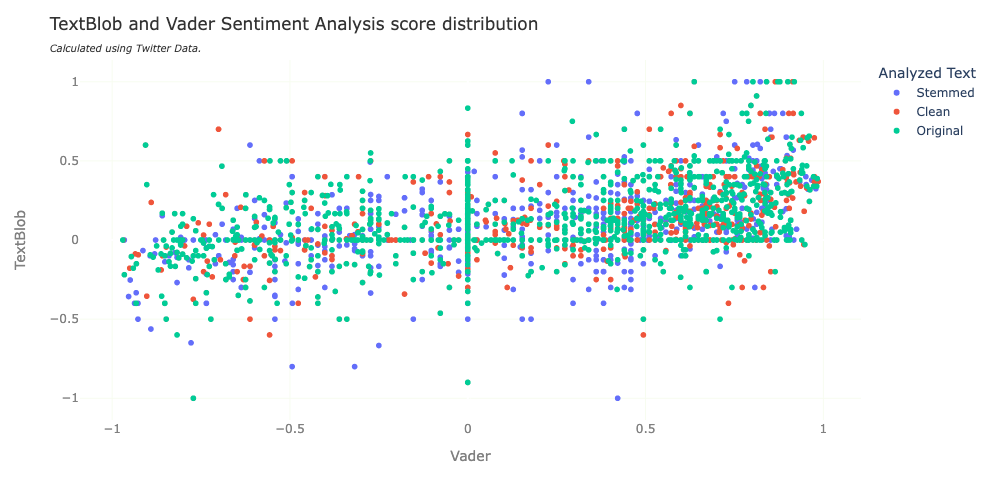

In [31]:

#Creating Df to plot
t = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['TextBlob','TextBlob_c', 'TextBlob_o'])
v = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['Vader_c','Vader','Vader_o'])

t = t.replace({'TextBlob' : 'Stemmed',
               'TextBlob_c' : 'Clean',
               'TextBlob_o' : 'Original'})
v = v.replace({'Vader' : 'Stemmed',
               'Vader_c' : 'Clean',
               'Vader_o' : 'Original'})

m = t.merge(v, how='inner', on=['index', 'variable'])
del t, v
m = m.drop('index', axis = 1).rename(columns={'value_x' : 'TextBlob', 'value_y':'Vader'})

m

title = f'TextBlob and Vader Sentiment Analysis score distribution' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig =px.scatter( y= m['TextBlob'], 
                x=m['Vader'],
               color = m['variable'])


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    yaxis_title_text = 'TextBlob',
    xaxis_title_text = 'Vader',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= "Analyzed Text")

In this graph it is possible to see the change in the dispersion of the points according to the treatment process, the more treated the data the more they accumulate in the 0 (neutral) axes.

## Sarcasm

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
news = pd.read_csv('sarcasm_headlines.bz2')
news.sample()

headline  is_sarcastic
13469  florida shooter's former friend says she repor...             0

In [34]:
print(news.isnull().any(axis = 0))

headline        False
is_sarcastic    False
dtype: bool


In [35]:
stemming(news, 'headline', 'headline_ps')

Stemmer done!


In [36]:
news.sample(2)

headline  is_sarcastic  \
24081  a tale of two kindergartens -- well, three now...             0   
24630       cashier allows line-cutting to go unpunished             1   

                                  headline_ps  
24081  tale two kindergarten well three think  
24630      cashier allow line cut go unpunish

In [37]:
def create_features(values, max_feat):
    features = values

    # vectorizing the data with maximum features
    tv = TfidfVectorizer(max_features = max_feat)
    #features = list(features)
    features = tv.fit_transform(features).toarray()
    
    return features

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. Let’s take sample example and explore two different spicy sparse matrix before go into deep explanation 

In [38]:
tweets.columns

Index(['public_metrics', 'conversation_id', 'text', 'reply_settings', 'lang',
       'author_id', 'edit_history_tweet_ids', 'created_at', 'id',
       'in_reply_to_user_id', 'referenced_tweets', 'country', 'geo', 'text_c',
       'keywords', 'text_ps', 'TextBlob', 'Vader', 'TextBlob_c', 'Vader_c',
       'TextBlob_o', 'Vader_o', 'TextBlob_desc', 'TextBlob_o_desc',
       'TextBlob_c_desc', 'Vader_desc', 'Vader_o_desc', 'Vader_c_desc'],
      dtype='object')

In [39]:
print(f'News Rows: {len(news.headline_ps)}')
feat = news['headline_ps'].to_list()

print(f'Tweets Rows: {len(tweets.text_ps)}')
feat.extend(tweets.text_ps.to_list())

print(f'Total Rows: {len(feat)}')

News Rows: 26709
Tweets Rows: 1409
Total Rows: 28118


In [40]:
features = create_features(feat, 9000)

X_features = features[:26709]
print(f'Features: {len(X_features)}')

X_pred = features[26709:]
print(f'Predictions: {len(X_pred)}')

labels = news['is_sarcastic'].to_list()
print(f'Labels: {len(labels)}')

Features: 26709
Predictions: 1409
Labels: 26709


In [41]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(X_features, labels, test_size = 0.2, random_state = 0)

In [42]:
%%time
print('\nLinear Support Vector Classifier:')
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print('Train: ',lsvc.score(features_train, labels_train))
print('Test: ',lsvc.score(features_test, labels_test))


print('\nGaussian Naive Bayes:')
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print('Train: ',gnb.score(features_train, labels_train))
print('Test: ',gnb.score(features_test, labels_test))


print('\nLogistic Regression:')
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print('Train: ',lr.score(features_train, labels_train))
print('Test: ',lr.score(features_test, labels_test))


print('\nRandom Forest Classifier:')
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print('Train: ',rfc.score(features_train, labels_train))
print('Test: ',rfc.score(features_test, labels_test))


Linear Support Vector Classifier:
Train:  0.9200636495530491
Test:  0.7845376263571696

Gaussian Naive Bayes:
Train:  0.7885524406795525
Test:  0.6636091351553726

Logistic Regression:
Train:  0.8618430289699068
Test:  0.7819168850617746

Random Forest Classifier:
Train:  0.9859128562736931
Test:  0.7418569824035942
CPU times: user 2min 38s, sys: 17.2 s, total: 2min 55s
Wall time: 2min 43s


### Cross-Validation

#### KFold

k-Fold cross-validation is a technique that minimizes the disadvantages of the hold-out method. k-Fold introduces a new way of splitting the dataset which helps to overcome the “test only once bottleneck”.

In [43]:
%%time
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)


print('\nLinear Support Vector Classifier:')
score = cross_val_score(lsvc, X_features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Linear Support Vector Classifier:
Scores for each fold are: [0.78023212 0.79558218 0.77779858 0.78903033 0.7785059 ]
Average score: 0.78
CPU times: user 13.1 s, sys: 7.22 s, total: 20.3 s
Wall time: 20.6 s


In [44]:
%%time
print('\nGaussuan Naive Bayes:')
score = cross_val_score(gnb, X_features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Gaussuan Naive Bayes:
Scores for each fold are: [0.67315612 0.67278173 0.65331337 0.65574691 0.64332522]
Average score: 0.66
CPU times: user 27.5 s, sys: 28.8 s, total: 56.2 s
Wall time: 1min 3s


In [45]:
%%time

print('\nLogistic Regression:')
score = cross_val_score(lr, X_features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Logistic Regression:
Scores for each fold are: [0.785848   0.79782853 0.78304006 0.78472482 0.78150159]
Average score: 0.79
CPU times: user 3min 53s, sys: 12.8 s, total: 4min 6s
Wall time: 2min 30s


In [46]:
%%time

print('\nRandom Forest Classifier:')
score = cross_val_score(rfc, X_features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Random Forest Classifier:
Scores for each fold are: [0.74429053 0.75215275 0.73961063 0.73830026 0.74237034]
Average score: 0.74
CPU times: user 6min 15s, sys: 13.9 s, total: 6min 29s
Wall time: 6min 37s


### Learning Curve

Determines cross-validated training and test scores for different training set sizes.

In [47]:
def get_learning_curve(model, X, y, cv, model_name):
    print(f'Getting Learning Curve for {model_name}')
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, 
                                                            y, 
                                                            cv=cv, 
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.01, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    print('Training Score:')
    print(f'Average: {"{:.2f}".format(train_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(train_scores.std())}')

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    print('\nTest Score:')
    print(f'Average: {"{:.2f}".format(test_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(test_scores.std())}')
    
    print('\n')
    
    plt.subplots(1, figsize=(7,5))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

Getting Learning Curve for Linear Support Vector Classifier
Training Score:
Average: 0.96
Standard Deviation: 0.03

Test Score:
Average: 0.74
Standard Deviation: 0.05




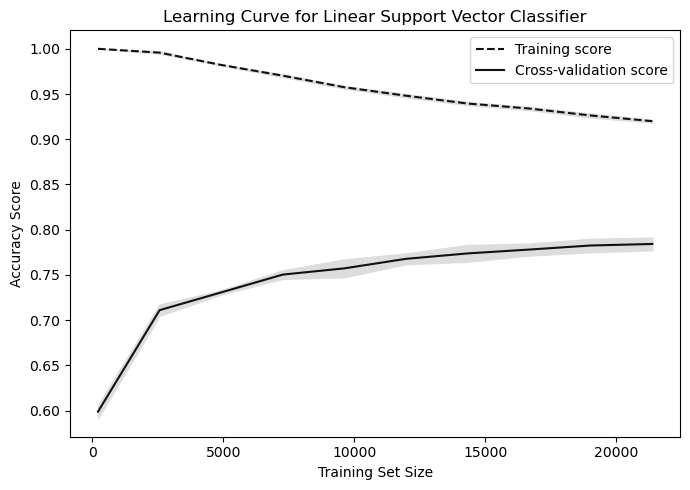

CPU times: user 1.23 s, sys: 1.99 s, total: 3.22 s
Wall time: 1min 52s


In [48]:
%%time
get_learning_curve(model = lsvc,
               X = X_features,
               y = labels,
               cv = kf,
               model_name = 'Linear Support Vector Classifier')

Getting Learning Curve for Logistic Regression
Training Score:
Average: 0.88
Standard Deviation: 0.03

Test Score:
Average: 0.74
Standard Deviation: 0.06




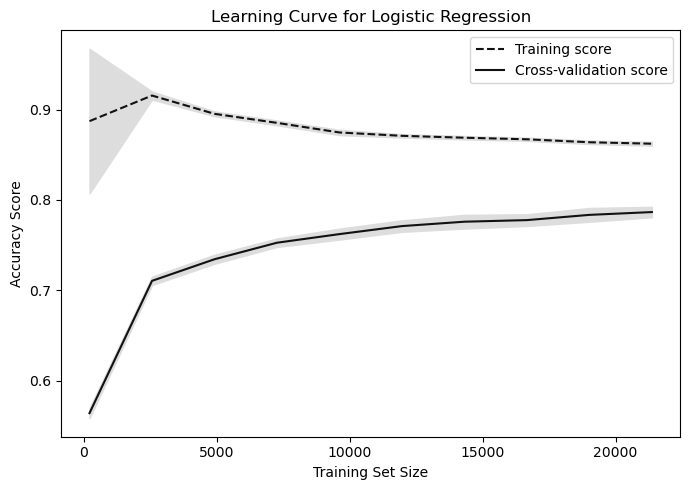

CPU times: user 1.54 s, sys: 2.82 s, total: 4.36 s
Wall time: 8min 57s


In [49]:
%%time
get_learning_curve(model = lr,
               X = X_features,
               y = labels,
               cv = kf,
               model_name = 'Logistic Regression')

Getting Learning Curve for Gaussuan Naive Bayes
Training Score:
Average: 0.84
Standard Deviation: 0.06

Test Score:
Average: 0.63
Standard Deviation: 0.03




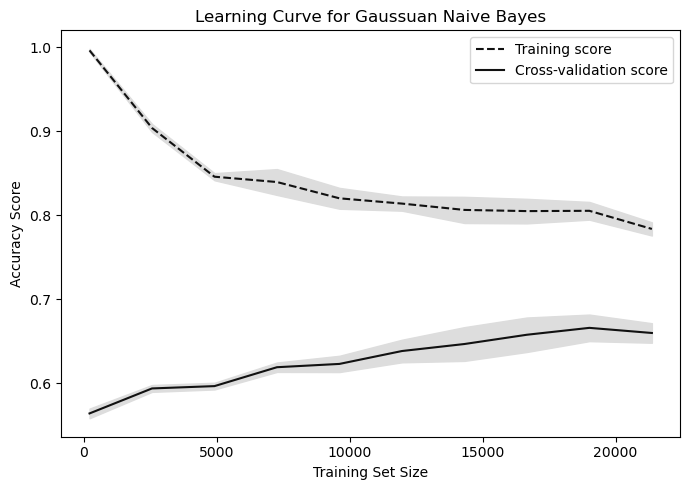

CPU times: user 1.47 s, sys: 2.94 s, total: 4.41 s
Wall time: 15min 5s


In [50]:
%%time
get_learning_curve(model = gnb,
               X = X_features,
               y = labels,
               cv = kf,
               model_name = 'Gaussuan Naive Bayes')

### Prev

In [51]:
tweets['is_sarcastic_lsvc'] = lsvc.predict(X_pred)

In [52]:
tweets['is_sarcastic_lr'] = lr.predict(X_pred)

In [53]:
tweets.sample(4)

public_metrics      conversation_id  \
1194  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1605331217263493121   
1043  {'retweet_count': 20, 'reply_count': 4, 'like_...  1604048011373400064   
1012  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1605502032919506944   
1076  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1606204264581300225   

                                                   text reply_settings lang  \
1194  Like why is DeSantis claiming to be able to ha...       everyone   en   
1043  Under Indo-German Cooperation on AMD Project, ...       everyone   en   
1012  Before we all start our holidays, we are pleas...       everyone   en   
1076  Lyxor Bloomberg Equal-weight Commodity ex-Agri...       everyone   en   

                author_id   edit_history_tweet_ids                created_at  \
1194  1497991149591662595  ['1605331217263493121']  2022-12-20T22:36:02.000Z   
1043           1461447398  ['1604048011373400064']  2022-12-17T09:37:02.000Z   
1012             34932200  ['1605502032919506944']  2022-12-21T09:54:48.000Z   
1076             42410755  ['1606204264581300225']  2022-12-23T08:25:13.000Z   

      id  in_reply_to_user_id  ... TextBlob_o Vader_o TextBlob_desc  \
1194 NaN                  NaN  ...  -0.233333 -0.4767      negative   
1043 NaN                  NaN  ...   0.700000  0.4404      positive   
1012 NaN                  NaN  ...   0.500000  0.6996       neutral   
1076 NaN                  NaN  ...   0.000000  0.3612       neutral   

      TextBlob_o_desc TextBlob_c_desc       Vader_desc     Vader_o_desc  \
1194    weak_negative   weak_negative  strong_negative         negative   
1043  strong_positive        positive         positive         positive   
1012         positive   weak_positive         positive  strong_positive   
1076          neutral         neutral         positive         positive   

         Vader_c_desc  is_sarcastic_lsvc  is_sarcastic_lr  
1194         negative                  1                1  
1043         positive                  1                1  
1012  strong_positive                  1                1  
1076         positive                  0                0  

[4 rows x 30 columns]

In [54]:
##Checking Twitters
def Check_tweet(n):
    print('Text Original:\n', tweets.loc[n, 'text'], '\n',
         '-------------------------------------------------------------------------------------------')
    print('Text Clear:\n', tweets.loc[n, 'text_c'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('Text Steammed:\n', tweets.loc[n, 'text_ps'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('KeyWords:\n', tweets.loc[n, 'keywords'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('\nCountry: ', tweets.loc[n, 'country'])

    print('\nTextBlob')
    print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
    print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
    print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

    print('\nVader')
    print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
    print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
    print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])

    print('\nSarcasm')
    print('LSVC: ', tweets.loc[n, 'is_sarcastic_lsvc'])
    print('LR: ', tweets.loc[n, 'is_sarcastic_lr'])


In [55]:
Check_tweet(300)

Text Original:
 A warm welcome to Sweden taking the EU Council Presidency today 🇪🇺🇸🇪.
I look forward to a constructive and successful cooperation in matters related to agriculture. #EU2023SE

Thank you 🇨🇿 Czech Council presidency @EU2022_CZ for your excellent work! #EU2022CZ https://t.co/d1Fpkaugo9 
 -------------------------------------------------------------------------------------------
Text Clear:
 A warm welcome to Sweden taking EU Council Presidency I look forward to a constructive successful cooperation in matters related to EU2023SE Thank you Czech Council presidency for your excellent work EU2022CZ 
 -------------------------------------------------------------------------------------------
Text Steammed:
 warm welcom sweden take eu council presid look forward construct success cooper matter relat eu se thank czech council presid excel work eu cz 
 -------------------------------------------------------------------------------------------
KeyWords:
 ['#EU2023SE', '#EU2022CZ']

In [56]:
t = tweets.copy()

t['is_sarcasm'] = t[['is_sarcastic_lsvc', 'is_sarcastic_lr']].sum(axis=1)
t = t['is_sarcasm'].replace({0: 'Not', 1: 'Diverge', 2:'Yes'})
tweets = pd.concat([tweets, t], axis = 1)
del t
tweets.sample(5)

public_metrics      conversation_id  \
1303  {'retweet_count': 1, 'reply_count': 0, 'like_c...  1604820133502918658   
126   {'retweet_count': 6, 'reply_count': 0, 'like_c...  1608674786464473088   
1280  {'retweet_count': 1, 'reply_count': 0, 'like_c...  1604902419900600321   
1350  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1604466562932805632   
43    {'retweet_count': 1, 'reply_count': 0, 'like_c...  1610018949139427328   

                                                   text reply_settings lang  \
1303  A new £4.8M project funded by the Department f...       everyone   en   
126   Hungary experienced the worst drought in livin...       everyone   en   
1280  @InnovelecSolut1, the UK agent for @emlid. Eml...       everyone   en   
1350  @BrandomainQuest https://t.co/UP38egPsk9 is au...       everyone   en   
43    Call for Projects Food Security 2023\nDeadline...       everyone   en   

                author_id   edit_history_tweet_ids                created_at  \
1303  1351171632040210440  ['1604820133502918658']  2022-12-19T12:45:10.000Z   
126   1295328361909235714  ['1608674786464473088']  2022-12-30T04:02:11.000Z   
1280            213802926  ['1604902419900600321']  2022-12-19T18:12:09.000Z   
1350           2960946087  ['1604466562932805632']  2022-12-18T13:20:12.000Z   
43    1276548550353137666  ['1610018949139427328']  2023-01-02T21:03:24.000Z   

                id  in_reply_to_user_id  ... Vader_o  TextBlob_desc  \
1303           NaN                  NaN  ...  0.3182  weak_positive   
126   1.608675e+18                  NaN  ... -0.8481  weak_negative   
1280           NaN         3.292897e+09  ...  0.3818        neutral   
1350           NaN         1.592405e+18  ...  0.0000        neutral   
43    1.610019e+18                  NaN  ...  0.7506  weak_positive   

     TextBlob_o_desc TextBlob_c_desc       Vader_desc     Vader_o_desc  \
1303   weak_positive   weak_positive    weak_negative         positive   
126    weak_negative   weak_negative  strong_negative  strong_negative   
1280         neutral         neutral         positive         positive   
1350         neutral         neutral          neutral          neutral   
43     weak_positive   weak_positive  strong_positive  strong_positive   

         Vader_c_desc  is_sarcastic_lsvc  is_sarcastic_lr  is_sarcasm  
1303         positive                  1                1         Yes  
126   strong_negative                  0                0         Not  
1280         positive                  0                1     Diverge  
1350          neutral                  0                0         Not  
43    strong_positive                  1                1         Yes  

[5 rows x 31 columns]

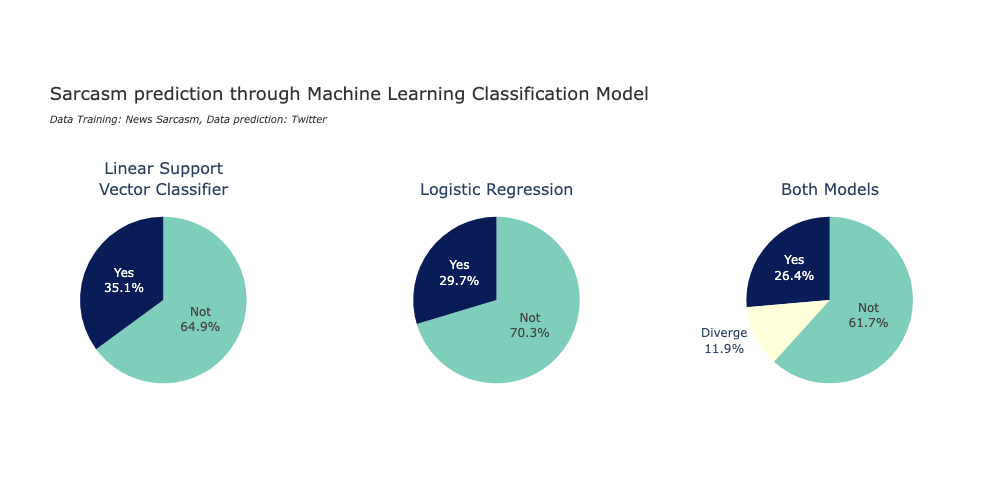

In [57]:
title = f'Sarcasm prediction through Machine Learning Classification Model' \
        f'<br><span style="font-size:10px"><i>Data Training: News Sarcasm, Data prediction: Twitter</span></i>'

fig = make_subplots(
    rows=1, cols=3,
    vertical_spacing=0.1,
    horizontal_spacing=0.2,
    specs=[[{"type": "domain"}, {"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("Linear Support<br>Vector Classifier",
                    "Logistic Regression",
                   "Both Models")

)

fig.add_trace(go.Pie(values=tweets['is_sarcastic_lsvc'].value_counts().values,
                    text =['Not','Yes']),
              row=1, col=1)

fig.add_trace(go.Pie(values=tweets['is_sarcastic_lr'].value_counts().values,
                     text = ['Not','Yes']),
              row=1, col=2)

fig.add_trace(go.Pie(values=tweets['is_sarcasm'].value_counts().values,
                     text = tweets['is_sarcasm'].value_counts().index),
              row=1, col=3)


fig.update_layout(
    showlegend=False,
    font_size=12,
    title_font_size=18,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    margin_t=200,
    margin_b=100)

fig.update_traces(marker=dict(colors=['#7fcdbb', '#081d58', "#ffffd9"]))

fig.show()

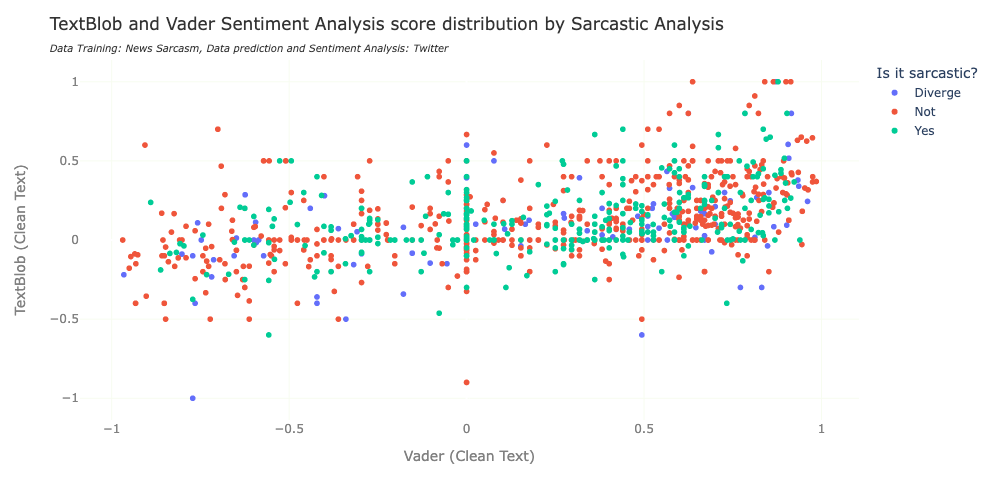

In [58]:
#Creating Df to plot
m = tweets

title = f'TextBlob and Vader Sentiment Analysis score distribution by Sarcastic Analysis' \
        f'<br><span style="font-size:10px"><i>Data Training: News Sarcasm, Data prediction and Sentiment Analysis: Twitter</span></i>'

fig =px.scatter( y= m['TextBlob_c'], 
                x=m['Vader_c'],
               color = m['is_sarcasm'])


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    yaxis_title_text = 'TextBlob (Clean Text)',
    xaxis_title_text = 'Vader (Clean Text)',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= "Is it sarcastic?")

#### Disagree

In [69]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Diverge'].sample(10).index

check = [1120, 717, 377, 1056, 946, 1221, 236, 684, 650, 1368]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 Hospitality trends for 2023 and beyond...

What are the latest trends:
•Sustainability - ✓
•Plant-based and regenerative agriculture - ✓
•Emerging cuisines - ✓

Find out more in our latest blog: https://t.co/FbY8PIRdE5

#hospitality #catering #sourcing #sustainability https://t.co/QiMKhCQC0E 
 -------------------------------------------------------------------------------------------
Text Clear:
 trends for beyond What latest trends Sustainability Plant regenerative Emerging cuisines out in our latest catering sourcing sustainability QiMKhCQC0E 
 -------------------------------------------------------------------------------------------
Text Steammed:
 trend beyond latest trend sustain plant regen emerg cuisin latest cater sourc sustain qimkhcqc e 
 -------------------------------------------------------------------------------------------
KeyWords:
 ['#hospitality', '#catering', '#sourcing', '#sustainability'] 
 ---------------------------------------------------------

#### Agree

##### Both positive

In [71]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Yes'].sample(10).index

check = [872, 874, 164, 1169, 1302, 1092, 504, 1215, 769, 371]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 @andersen_inger @UrosBrezan @SLOtoUN @UNEP_Europe @rs_mop @MOEPPMKD I have solutions to increase water sources reducing atmosphere temperature with 15C stopping glaciers melting, eliminating smog of Santiago, to prevent forest fires, to make grassland, agriculture land, forest, în slop,desert, mechanized, efficient, cheap Please send answer Thank 
 -------------------------------------------------------------------------------------------
Text Clear:
 I have to increase water sources reducing atmosphere temperature with 15C stopping glaciers melting eliminating smog of Santiago to prevent forest fires to make grassland land forest în slop desert mechanized efficient cheap Please send answer Thank 
 -------------------------------------------------------------------------------------------
Text Steammed:
 increas water sourc reduc atmospher temperatur c stop glacier melt elimin smog santiago prevent forest fire make grassland land forest n slop desert mechan effici cheap

##### Both Negative

In [73]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Not'].sample(10).index

check = [1204, 527, 519, 1259, 27, 531, 1209, 1144, 545, 434]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 @johnmuffit @AnneJackson18 @digitalsunshine Land is more expensive in the uk because we are a tiny island. Land has to be used for agriculture, Forestry. Then there are areas of mountains, lakes national parks which cannot be used If you stuff it full of people then of course land values will rise. 
 -------------------------------------------------------------------------------------------
Text Clear:
 Land is expensive in because we a tiny island Land has to be used for Forestry Then of mountains lakes parks which cannot be used you stuff it of people then of course land values will rise 
 -------------------------------------------------------------------------------------------
Text Steammed:
 land expens tini island land use forestri mountain lake park cannot use stuff peopl cours land valu rise 
 -------------------------------------------------------------------------------------------
KeyWords:
 [] 
 --------------------------------------------------------------

# Word Cloud

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [63]:
def Plot_WordCloud(data, column_words, drop_word = [], min_df = .01, max_df = .6, figsize=[12,8]):

    vectorizer = TfidfVectorizer(stop_words='english', min_df = min_df, max_df = max_df) #ngram_range = (1,1)
    X = vectorizer.fit_transform(data[column_words])
    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)


    #removing words
    
    for d in drop_word:
        try:
            df = df.drop(d , axis = 1)
        except:
            pass

    df = df.T
    df['total'] = df.sum(axis=1)

    print(f'Total of words: {len(df)}')

    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', 
                          background_color="white", 
                          width=3000, 
                          height=2000, 
                          max_words=500
                         ).generate_from_frequencies(df['total'])

    plt.figure(figsize=[12,8])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");

## All Sentiment

Total of words: 259


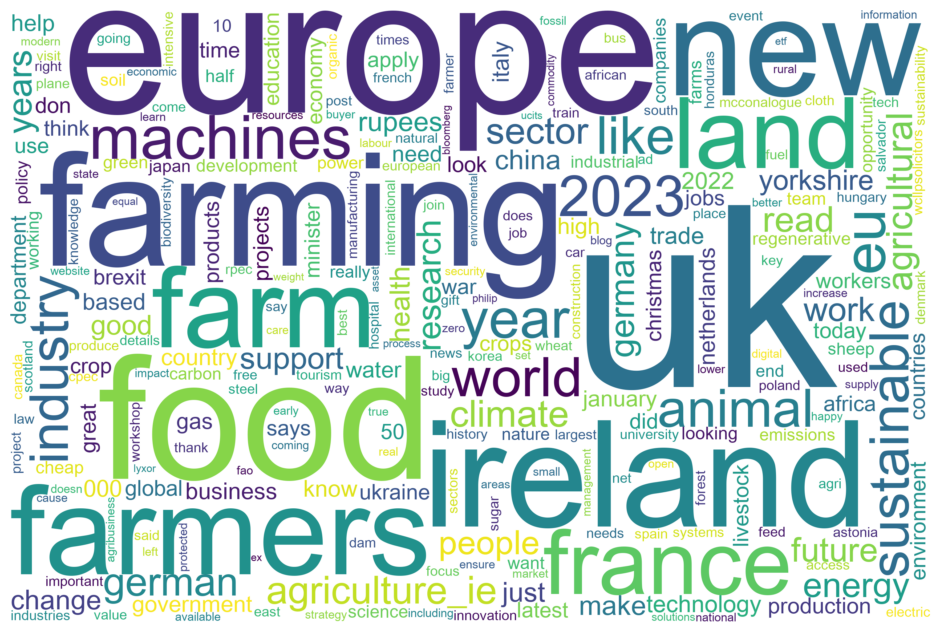

In [64]:
Plot_WordCloud(data = tweets,
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Negative Sentiment

Total of words: 339


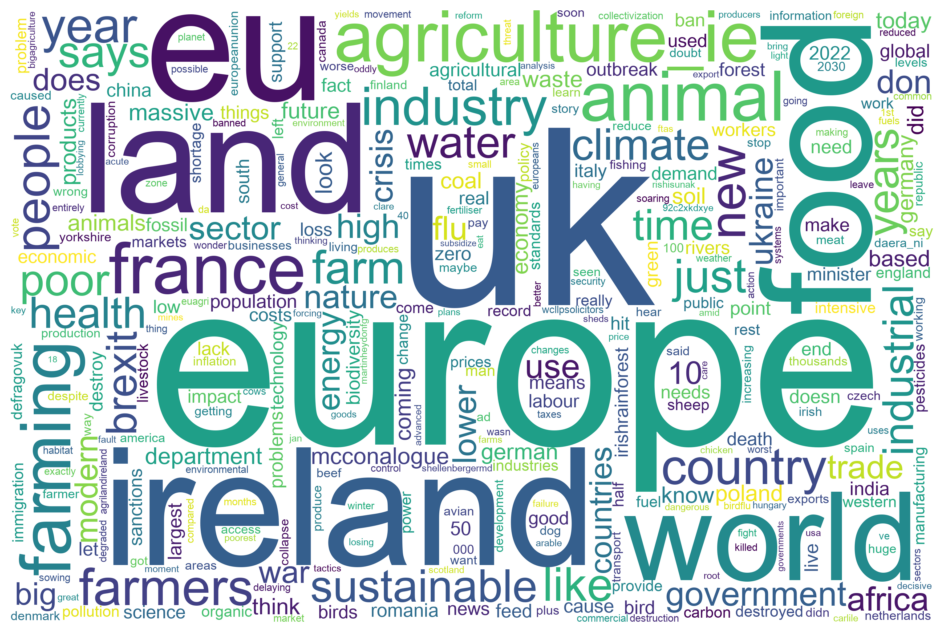

In [65]:
neg_sent = ['weak_negative','negative','strong_negative']

Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(neg_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Positive Sentiment

Total of words: 265


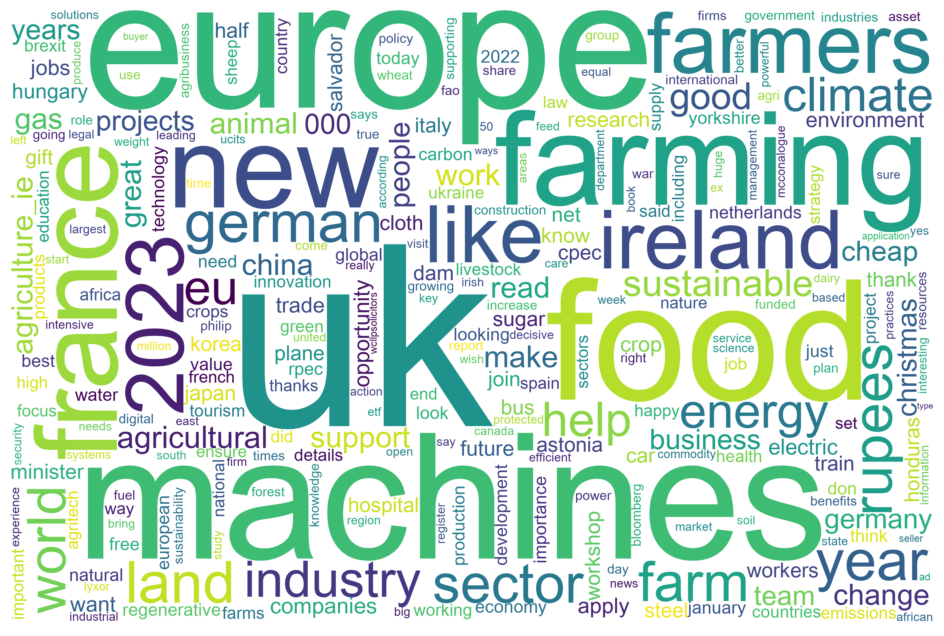

In [66]:
pos_sent = ['strong_positive','positive','weak_positive']
Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(pos_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Neutral Sentiment

Total of words: 315


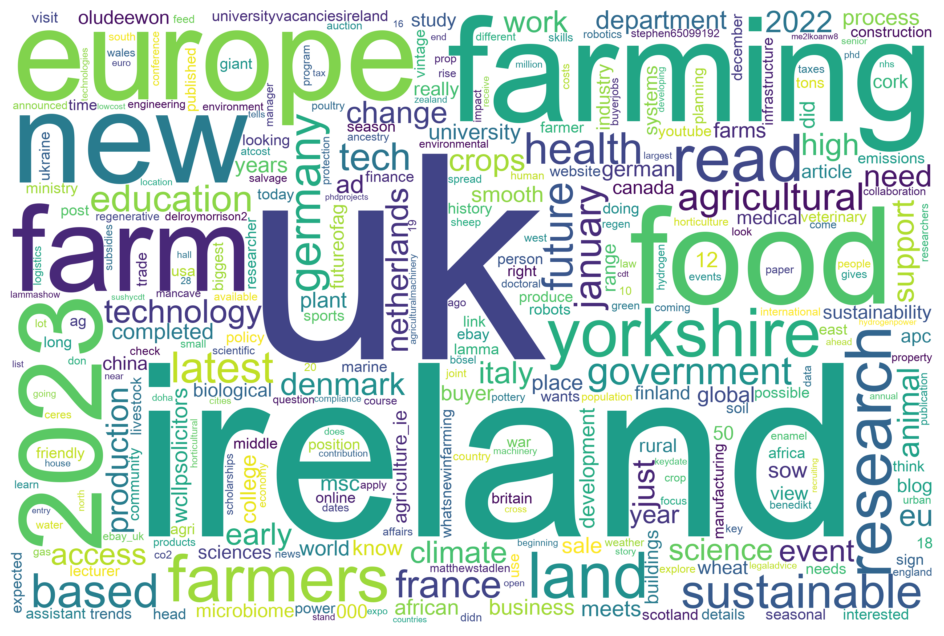

In [67]:
neu_sent = ['neutral']

Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(neu_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])